In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.distributions as dist
import torch
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

from torch.utils.data import Dataset, DataLoader
from scripts.utils import ScaleData, train_keys
from scripts.AutoEncoder import Encoder, Decoder, AutoEncoderDataset

import itertools
import seaborn as sns
%matplotlib notebook

In [2]:
device = torch.device("cpu")

In [3]:
def ELBO(encoder, decoder, X):
        # calculate the ELBO loss
        q_z_given_x = encoder.forward(X)

        q_samples = q_z_given_x.rsample()

        ones = torch.ones(2)
        zeros = torch.zeros(2)
        
#         if torch.cuda.is_available():
#             ones.cuda()
#             zeros.cuda()
#             q_samples.cuda()
        
        latent_prior = dist.Normal(zeros, ones)
             
        log_p_z = latent_prior.log_prob(q_samples).sum(-1)

        log_q_z_given_x = q_z_given_x.log_prob(q_samples).sum(-1)

        log_p_x_given_z = decoder.forward(q_samples).log_prob(X).sum(dim=1)
        
        ELBO = log_p_x_given_z + log_p_z - log_q_z_given_x

        return ELBO

In [4]:
encoder = Encoder(2, 15, VAE = True)
decoder = Decoder(2, 15, VAE = True) 

In [5]:
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
train_data = AutoEncoderDataset(train_data_path, columns = train_keys, train = True)
train_data.data = train_data.data.sample(100_000)
train_data.scale()

train_loader = DataLoader(train_data, shuffle = True, batch_size = 2048)

valid_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
valid_data = AutoEncoderDataset(valid_data_path, columns = train_keys, train = True)
valid_data.data = valid_data.data.sample(100_000)
valid_data.scale()

valid_loader = DataLoader(valid_data, shuffle = True, batch_size = 2048)

In [6]:
# if torch.cuda.is_available():
#     encoder = encoder.cuda()
#     decoder = decoder.cuda() 

opt_vae = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
N_epochs = 50 # Note that you may want to run more than 10 epochs!
for epoch in range(N_epochs):
    train_loss = 0.0
    for X in train_loader:
#         if torch.cuda.is_available():
#             X = X.cuda()

        opt_vae.zero_grad()
        loss = -ELBO(encoder, decoder, X).mean()
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(train_data)
    print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

Epoch 0, train loss = 21.6942
Epoch 1, train loss = 21.4322
Epoch 2, train loss = 21.3592
Epoch 3, train loss = 21.3411
Epoch 4, train loss = 21.2885
Epoch 5, train loss = 21.2405
Epoch 6, train loss = 21.1282
Epoch 7, train loss = 20.6620
Epoch 8, train loss = 18.5174
Epoch 9, train loss = 15.5022
Epoch 10, train loss = 12.4470
Epoch 11, train loss = 8.5672
Epoch 12, train loss = 6.8192
Epoch 13, train loss = 6.4929
Epoch 14, train loss = 5.4888
Epoch 15, train loss = 7.1421
Epoch 16, train loss = 5.6924
Epoch 17, train loss = 5.0145
Epoch 18, train loss = 4.3050
Epoch 19, train loss = 6.1908
Epoch 20, train loss = 4.7091
Epoch 21, train loss = 4.0397
Epoch 22, train loss = 4.1267
Epoch 23, train loss = 4.1862
Epoch 24, train loss = 3.3924
Epoch 25, train loss = 6.8176
Epoch 26, train loss = 4.7054
Epoch 27, train loss = 4.0667
Epoch 28, train loss = 3.6480
Epoch 29, train loss = 3.2045
Epoch 30, train loss = 2.8345
Epoch 31, train loss = 2.5108
Epoch 32, train loss = 3.9631
Epoch 33,

In [7]:
X_random_batch = next(iter(valid_loader))
X_random_batch.shape

torch.Size([2048, 15])

In [8]:
with torch.no_grad():    
    out = encoder(X_random_batch).sample()

<IPython.core.display.Javascript object>


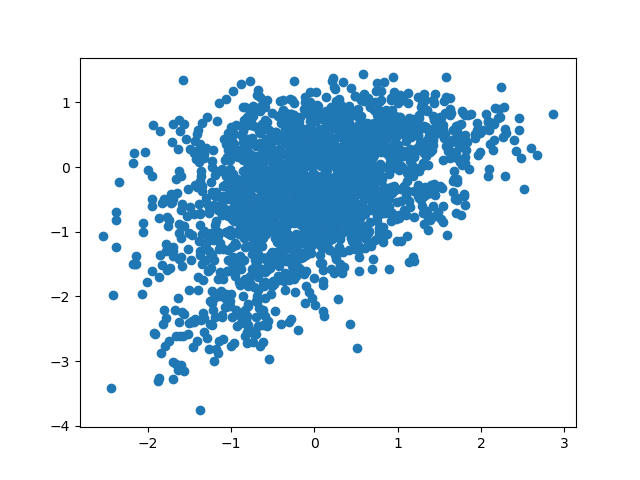

In [9]:
plt.figure()
plt.scatter(out[:,0], out[:,1])

In [10]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

df_test = pd.read_pickle(test)
df_test = df_test.sample(10_000)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]

df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03,6.640000e+03
mean,-6.978448e-17,-8.420724e-17,-5.288942e-16,-2.410053e-16,7.967188e-17,2.205398e-17,-4.332545e-16,-1.855736e-17,-7.795806e-19,-7.069312e-17,-2.255141e-17,1.905688e-17,1.174429e-16,8.672280e-16,3.233692e-17
std,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-6.845754e+00,-6.371173e+00,-1.749049e+01,-1.787121e+00,-1.565196e+00,-1.273361e+00,-2.024214e+01,-1.209308e+00,-2.019406e+00,-2.720614e+00,-1.423615e+01,-6.770256e+00,-1.741873e+00,-3.070346e+00,-2.617869e+00
25%,-4.186228e-01,-5.633395e-01,-2.816705e-01,-5.171418e-01,-9.698262e-01,-8.005172e-01,5.106996e-02,-7.424203e-01,-6.533745e-01,-4.716698e-01,-3.341631e-01,-5.335030e-01,-2.736305e-01,-9.932006e-02,-7.266158e-01
50%,-2.113955e-01,-2.491672e-01,-2.816705e-01,-5.171418e-01,-1.363426e-01,-1.562986e-01,5.106996e-02,-2.897500e-01,-3.836439e-01,-3.332791e-01,-1.906041e-01,-2.451188e-01,-2.133404e-01,-9.932006e-02,-1.336510e-01
75%,8.544694e-02,1.962401e-01,-3.244030e-02,1.024664e-01,9.326222e-01,5.068481e-01,5.106996e-02,4.446861e-01,2.867453e-01,8.562877e-02,3.469841e-02,2.664604e-01,-1.017711e-01,-9.932006e-02,5.908324e-01
max,1.115447e+01,8.584925e+00,1.764793e+01,5.511609e+00,1.666036e+00,1.271250e+01,1.367118e+01,7.202677e+00,6.737304e+00,1.813024e+01,1.333185e+01,1.226486e+01,1.733606e+01,2.050938e+01,4.655364e+00


<IPython.core.display.Javascript object>


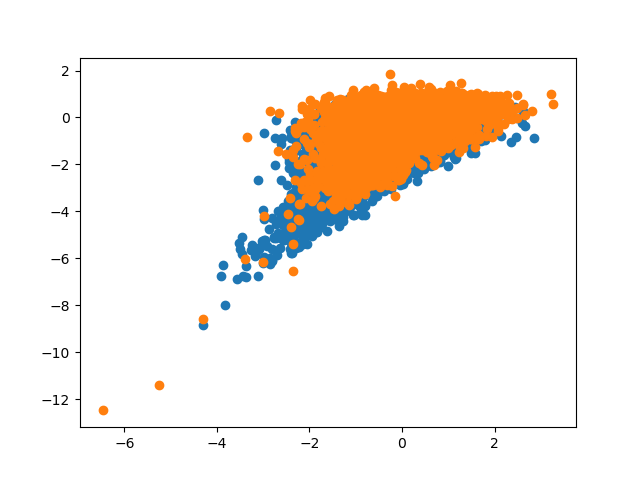

In [11]:
data_good = torch.from_numpy(df_test_good.values).float()
data_bad = torch.from_numpy(df_test_bad.values).float()
#data_good_batch = next(iter(data_good_loader))
with torch.no_grad():
    outputs_good = encoder.forward(data_good).sample()
    outputs_bad = encoder.forward(data_bad).sample()
#    outputs_good = encoder.forward(data_good).sample().detach().numpy()
    
plt.figure()
plt.scatter(outputs_good[:,0], outputs_good[:,1])
plt.scatter(outputs_bad[:,0], outputs_bad[:,1])

In [12]:
AE_output = decoder.forward(encoder.forward(data_good).sample()).sample().detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [13]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(10_000)

<IPython.core.display.Javascript object>


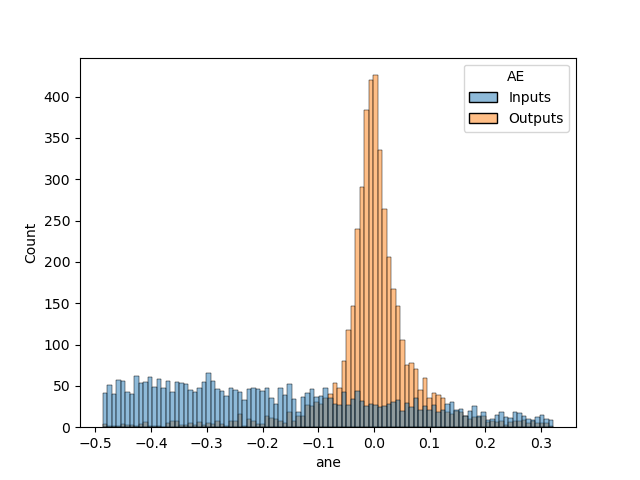

<IPython.core.display.Javascript object>


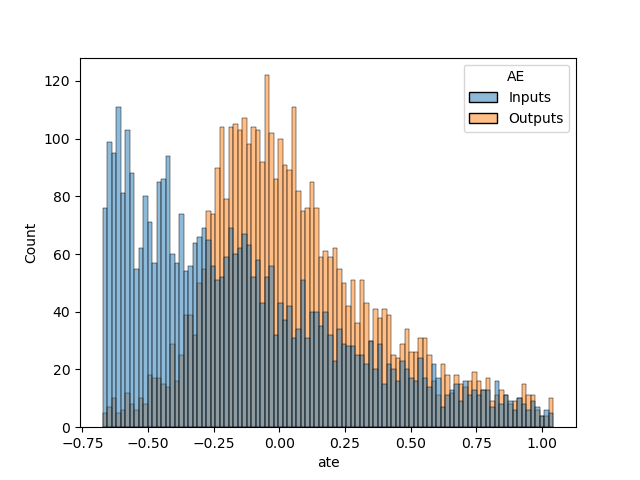

<IPython.core.display.Javascript object>


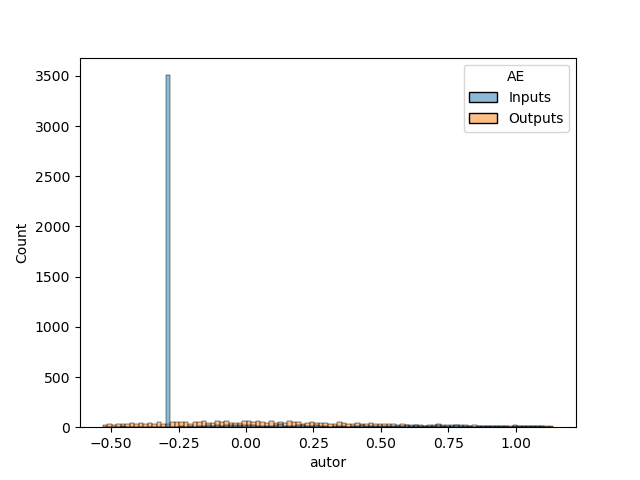

<IPython.core.display.Javascript object>


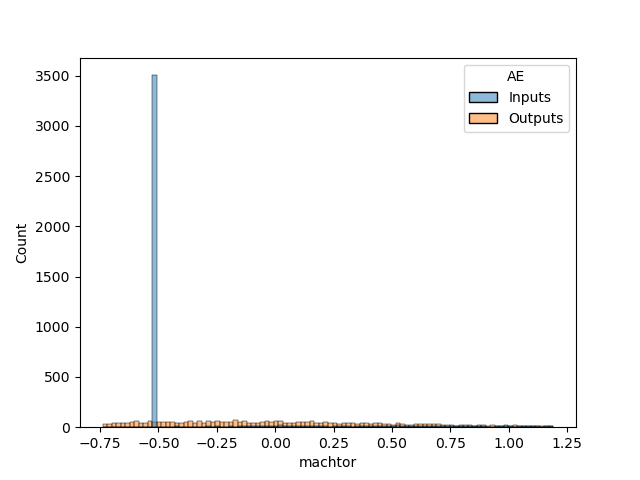

<IPython.core.display.Javascript object>


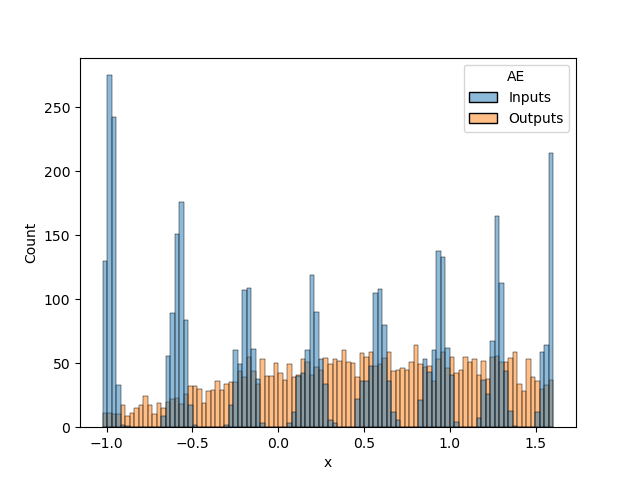

<IPython.core.display.Javascript object>


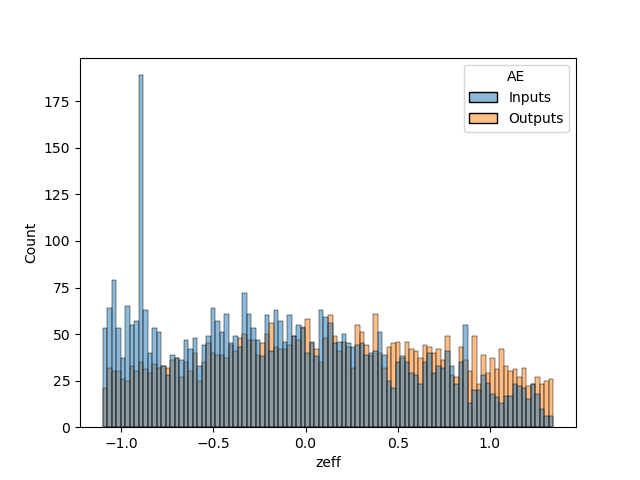

<IPython.core.display.Javascript object>


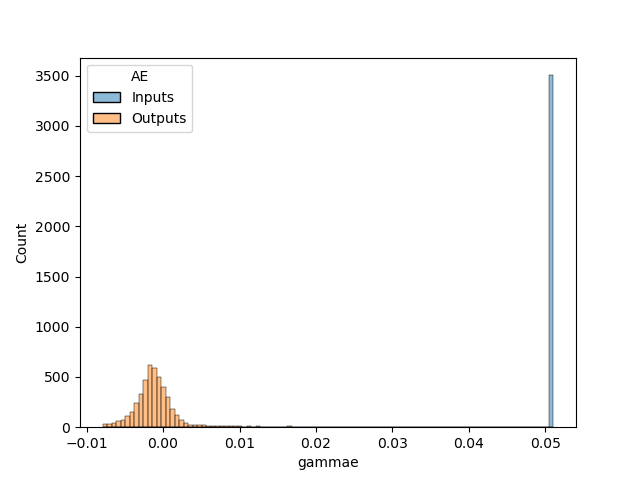

<IPython.core.display.Javascript object>


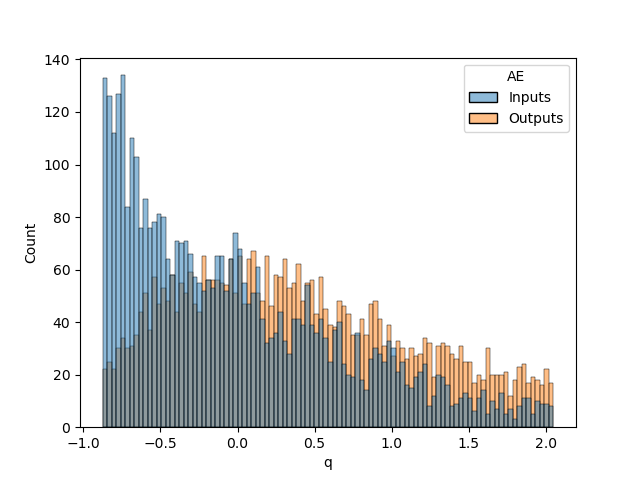

<IPython.core.display.Javascript object>


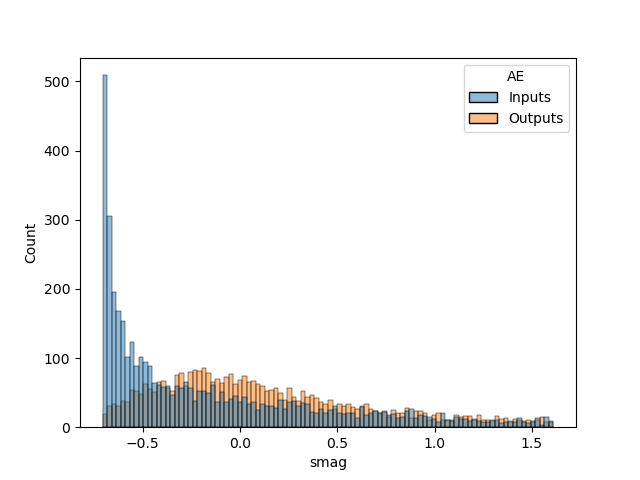

<IPython.core.display.Javascript object>


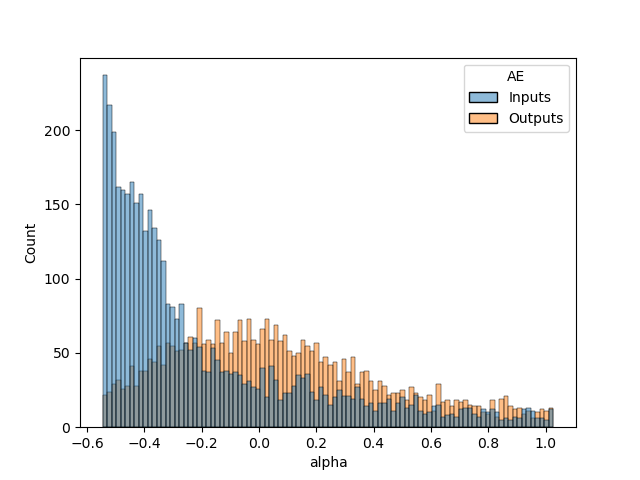

<IPython.core.display.Javascript object>


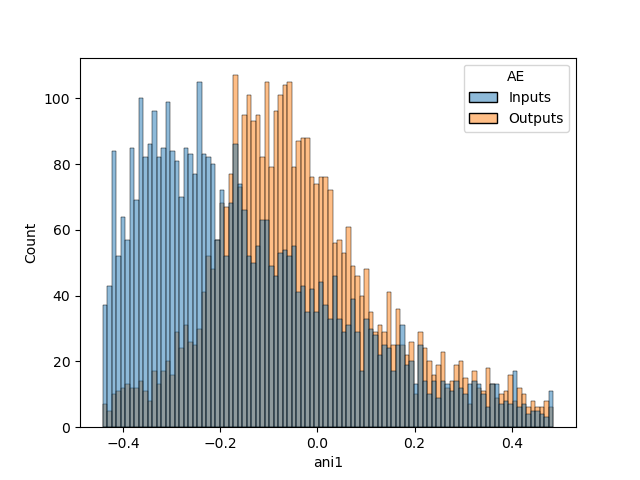

<IPython.core.display.Javascript object>


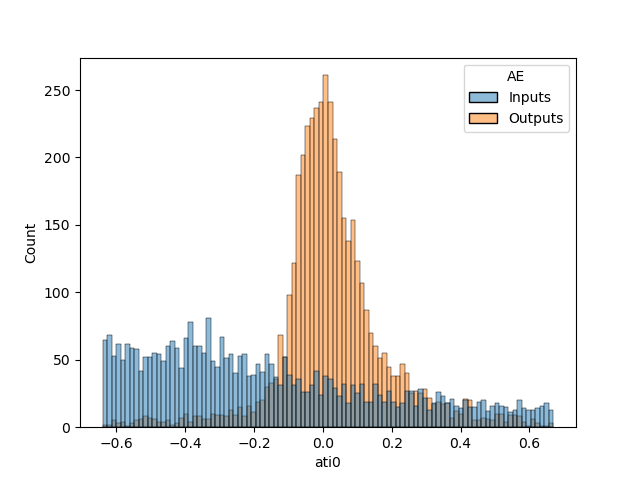

<IPython.core.display.Javascript object>


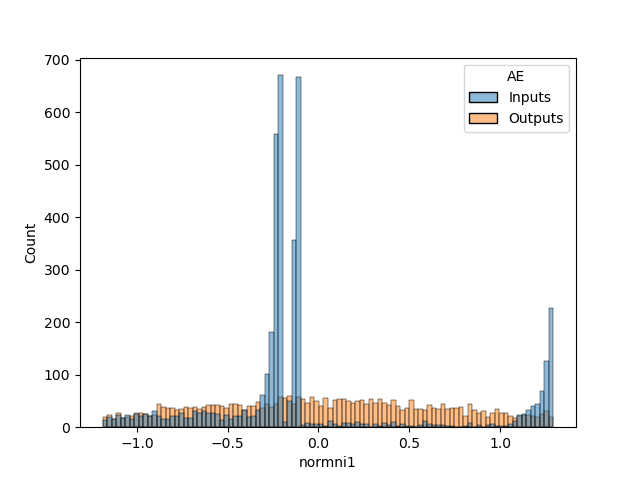

<IPython.core.display.Javascript object>


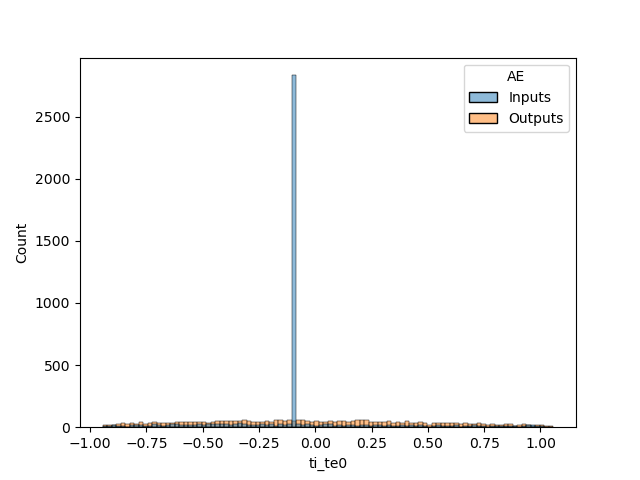

<IPython.core.display.Javascript object>


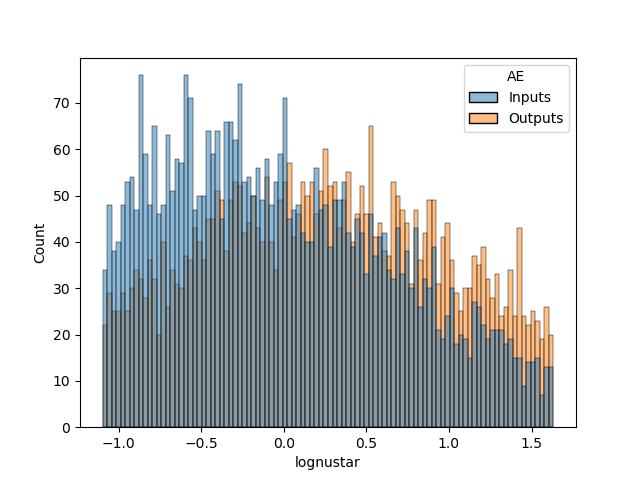

In [14]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)